In [1]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Reading spectra

In [3]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])

### Using a pre-processing pipeline

In [4]:
scaled, scaler = log_standard(pk_all)

### Using mock data here, will be rescaled as well

In [5]:
params = np.arange(scaled.shape[0]).reshape(-1, 1)
scaled_y, scaler_y = minmax(params)

In [6]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

Text(0, 0.5, 'Pk')

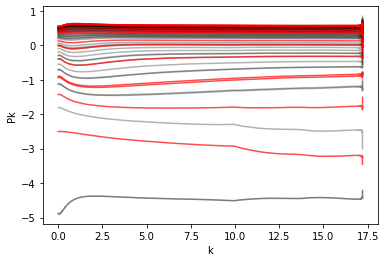

In [7]:
plt.figure(1)
plt.plot(k, pk_train.T, 'k', alpha=0.3)
plt.plot(k, pk_test.T, 'r', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Sample neural network 

### Fixing the network architecture (hidden_dims is flexible)

In [ ]:
mlp = simple_mlp(input_shape=param_train.shape[1], output_shape=pk_train.shape[1], hidden_dims=[16, 32, 64, 512])

### Set-up hyper-parameters

In [ ]:
learning_rate = 0.01
decay_rate = 0.1
batch_size = 4
num_epochs = 10

In [ ]:
mlp, train_history = train_mlp(mlp, 
                    param_train, pk_train, param_test, pk_test, 
                    learning_rate, decay_rate, batch_size, num_epochs)

In [ ]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

## explainers 

In [ ]:
## local SHAP model
## global ALE model